# 7 - Working with Plate Tectonic Stats
In this notebook, we use GPlately to calculate plate tectonic stats like the:

- Total length of all mid-ocean ridges (km)
- Mean ridge spreading velocity (spreading rate) (cm/yr)
- Mean ridge spreading velocity standard deviation (cm/yr)
- Crustal surface area produced over 1 yr at ridges (km^2/yr)
- Total length of all subduction zones (km)
- Mean subduction velocity (convergence rate) (cm/yr)
- Mean subduction velocity standard deviation (cm/yr)
- Crustal surface area subducted by trenches over 1 yr (km^2/yr)
- Length of all transform boundaries (km)

for a given plate model (a GPlately `PlateReconstruction` object) and a `reconstruction_time`. 

First, let's load our modules:

In [1]:
import gplately
import numpy as np
import pygplates
import ptt
import glob, os
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

Define `get_plate_tectonic_stats` and obtain plate tectonic stats for the Muller et al. 2019 model.

In [2]:
gdownload = gplately.download.DataServer("Muller2019")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

time = 0 #Ma
coastlines, continents, COBs = gdownload.get_topology_geometries()
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

Checking whether the requested files need to be updated...
Requested files are up-to-date!
Checking whether the requested files need to be updated...
Requested files are up-to-date!


In [3]:
# Function to obtain plate tectonic stats at a specific reconstruction time
def get_plate_tectonic_stats(model, reconstruction_time):
    
    # PlotTopologies collects plate boundaries from a plate model
    gplot = gplately.plot.PlotTopologies(model, reconstruction_time)
    boundary_features = [
        gplot.ridge_transforms, 
        gplot.ridges, 
        gplot.transforms, 
        gplot.trenches, 
        gplot.trench_left, 
        gplot.trench_right, 
        gplot.other
    ]
    # Find the lengths of these boundaries in km
    len_ridge_transform, len_ridge, len_transform, len_subd, len_subd_l, len_subd_r, len_other =  \
        ptt.resolve_topologies.find_total_boundary_length_in_kms(*boundary_features)

    # -----------------------   MID-OCEAN RIDGES   ------------------------------
    # Calculate mid ocean ridge stats with GPlately
    ridge_data = model.tesselate_mid_ocean_ridges(reconstruction_time, ignore_warnings=True)
    
    # Ignore data of ridge segments with negative velocities 
    ridge_data = ridge_data[ridge_data[:,2] >= 0]
    
    # Latitudes and longitudes of points along ridge segments
    ridge_lon = ridge_data[:,0]
    ridge_lat = ridge_data[:,1]
    
    # Global mid-ocean ridge length at this reconstruction time (km)
    ridge_len = sum(np.radians(ridge_data[:,3]) * gplately.tools.geocentric_radius(ridge_data[:,1])) * 1e-3
    # print(len_ridge, ridge_len)
    
    # Mean ridge spreading velocity + its standard deviation (in cm/year)
    ridge_vel = ridge_data[:,2]  # spreading velocities of ridge segments in cm/yr
    ridge_vel_mean = np.mean(ridge_vel) # mean global spreading velocity amongst all ridge segments in cm/yr
    ridge_vel_std = np.std(ridge_vel) # standard deviation
    
    # Ridge surface area (km^2/yr)
    # Convert ridge velocities from cm/yr to m/yr; ridge lengths are already in km
    ridge_surface_area = ridge_vel_mean * 1e-5 * ridge_len
    
    
    # -----------------------   SUBDUCTION ZONES   ------------------------------
    # Calculate subduction convergence stats with GPlately
    subduction_data = model.tesselate_subduction_zones(tereconstruction_time, ignore_warnings=True)
    
    # Latitudes and longitudes of points along trench segments
    subduction_lon = subduction_data[:,0]
    subduction_lat = subduction_data[:,1]
    
    # Global subduction zone length at this reconstruction time (km)
    subduction_len  = sum(np.radians(subduction_data[:,6]) * gplately.tools.geocentric_radius(subduction_data[:,1])) * 1e-3 
    
    # Ensure convergence velocities are positive
    subduction_data[:,2] = np.clip(subduction_data[:,2], 0.0, 1e99)
    
    # Multiply convergence velocities by the cosine of the subduction obliquity angle to get
    # subduction velocities (cm/yr)
    subduction_vel = np.fabs(subduction_data[:,2]) * np.cos(np.radians(subduction_data[:,3]))
    
    # Global mean subduction velocity and stdev of all trench segments (cm/year)
    subd_vel_mean, subd_vel_std = np.mean(subduction_vel), np.std(subduction_vel)
    
    # Area subducted by trenches over 1 yr (km^2/yr)
    # Convert subduction velocities from cm/yr to km/yr; trench lengths are already in km.
    subd_surface_area = subd_vel_mean * 1e-5 * subduction_len

    # Return a set of boundary stats in a tuple
    data = (
        reconstruction_time, len_ridge, ridge_vel_mean, ridge_vel_std, \
        ridge_surface_area, len_subd, subd_vel_mean, subd_vel_std, subd_surface_area, len_transform
    )
    
    return data

Let's obtain Muller2019 plate tectonic stats from 250Ma to present day.

In [4]:
# Create a time array
min_time = 0 
max_time = 250
time_array = np.arange(max_time,min_time-1, -1)

# Initialise data ndarray
data_array = np.zeros((10,time_array.size))

# Get plate tectonic stats for each reconstruction time
for t, time in enumerate(time_array):
    data_array[:,t] = get_plate_tectonic_stats(model, time)
    #print("Calculated stats for {} Ma!".format(time))
print("Done calculating stats!")

Done calculating stats!


### Save plate tectonic stats to a CSV file

In [5]:
headers = ['Time (Ma)',
'Global mid-ocean ridge lengths (km)',
'Mean global ridge velocities (cm/yr)',
'Global ridge velocity standard deviation (cm/yr)',
'Surface area of crust produced at ridges (km^2/yr)',
'Global subduction zone lengths (km)',
'Mean global subduction velocities (cm/yr)',
'Global subduction velocity standard deviation (cm/yr)',
'Surface area of crust subducted at trenches (km^2/yr)',
'Global transform boundary lengths (km)']

# Turn data array into a pandas dataframe.
muller19_df = pd.DataFrame(np.column_stack(data_array), columns = headers)

# Save dataframe to CSV
muller19_df.to_csv('./NotebookFiles/Muller2019-PlateTectonicStats.csv', encoding='utf-8', index=False)

## Plotting plate tectonic stats
As an example, let's plot the ridge spreading rate and trench convergence rate for Müller et al. 2019 as a function of time.

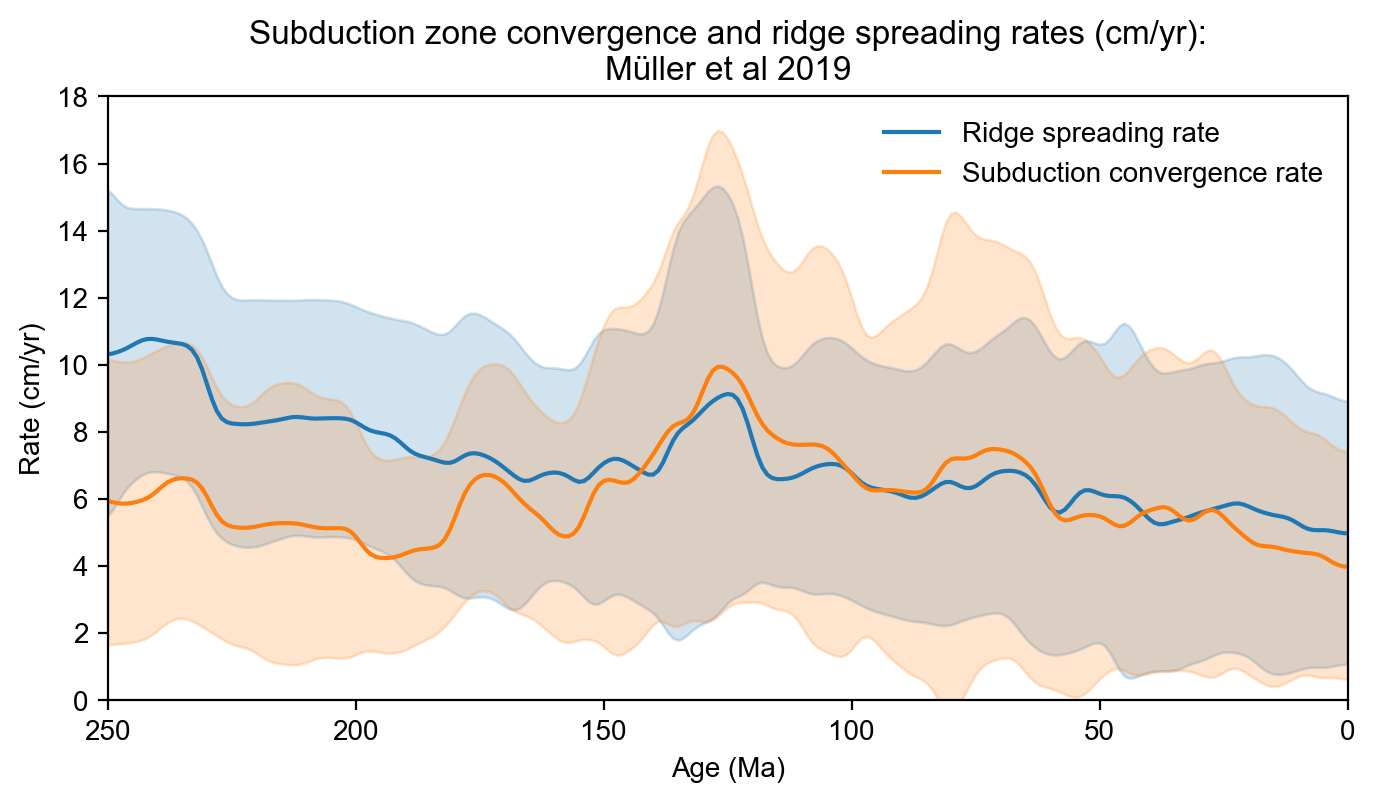

In [6]:
# Smooth data with a Gaussian filter
from scipy.ndimage import gaussian_filter

# Get stats from the data frame
reconstruction_times = muller19_df['Time (Ma)'].to_list()
ridge_vels_mean = muller19_df['Mean global ridge velocities (cm/yr)'].to_list()
ridge_vels_std = muller19_df['Global ridge velocity standard deviation (cm/yr)'].to_list()
subd_vels_mean = muller19_df['Mean global subduction velocities (cm/yr)'].to_list()
subd_vels_std = muller19_df['Global subduction velocity standard deviation (cm/yr)'].to_list()

# Use a Gaussian filter
ridge_vels_mean_smoothed = gaussian_filter(ridge_vels_mean, sigma=2)
subd_vels_mean_smoothed = gaussian_filter(subd_vels_mean, sigma=2)

# Plotting functions
fig = plt.figure(figsize=(8, 4), dpi=200)
plt.rcParams['font.family'] = 'Arial'
ax1 = fig.add_subplot(111, xlim=(250,0), ylim=(0,18), xlabel='Age (Ma)', ylabel="Rate (cm/yr)",
                      title="Subduction zone convergence and ridge spreading rates (cm/yr):\nMüller et al 2019")

ax1.plot(reconstruction_times, ridge_vels_mean_smoothed, label="Ridge spreading rate")
ax1.fill_between(reconstruction_times, 
                 gaussian_filter(ridge_vels_mean_smoothed-ridge_vels_std, sigma=2), 
                 gaussian_filter(ridge_vels_mean_smoothed+ridge_vels_std, sigma=2),
                 edgecolor='k', color='C0', alpha=0.2)

ax1.plot(reconstruction_times, subd_vels_mean_smoothed, label="Subduction convergence rate")  
ax1.fill_between(reconstruction_times, 
                 gaussian_filter(subd_vels_mean_smoothed-subd_vels_std, sigma=2), 
                 gaussian_filter(subd_vels_mean_smoothed+subd_vels_std, sigma=2),
                 edgecolor='k', color='C1', alpha=0.2)
plt.legend(loc="upper right", frameon=False)

### Calculate plate tectonic stats of other plate models
We repeat the workflow above to calculate the plate tectonic stats of two additional plate reconstruction models:

1. Muller et al. 2016
2. Merdith 2021



In [7]:
# MULLER ET AL 2016
# Create a time array
min_time = 0 
max_time = 230
muller16_time_array = np.arange(max_time,min_time-1, -1)

# Initialise data ndarray
muller16_data = np.zeros((10,muller16_time_array.size))

# Create the PlateReconstruction object with Muller et al 2016
gdownload = gplately.download.DataServer("Muller2016")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()
muller2016 = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Get plate tectonic stats for Muller et al 2016
for t, time in enumerate(muller16_time_array):
    muller16_data[:,t] = get_plate_tectonic_stats(muller2016, time)
    #print("Calculated stats for {} Ma!".format(time))
print("Done calculating stats!")

Checking whether the requested files need to be updated...
Requested files are up-to-date!
Done calculating stats!


In [8]:
# Turn the Muller et al 2016 plate tectoncic stats array into a pandas dataframe.
muller16_df = pd.DataFrame(np.column_stack(muller16_data), columns = headers)

# Save dataframe to CSV
muller16_df.to_csv("./NotebookFiles/Muller2016-PlateTectonicStats.csv", encoding='utf-8', index=False)

In [9]:
# MERDITH 2021
# Create a time array
min_time = 0 
max_time = 250
merdith21_time_array = np.arange(max_time,min_time-1, -1)

# Initialise data ndarray
merdith21_data = np.zeros((10,merdith21_time_array.size))

# Create the PlateReconstruction object with Merdith 2021
gdownload = gplately.download.DataServer("Merdith2021")
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()
merdith2021 = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Get plate tectonic stats for Merdith 2021
for t, time in enumerate(merdith21_time_array):
    merdith21_data[:,t] = get_plate_tectonic_stats(merdith2021, time)
    #print("Calculated stats for {} Ma!".format(time))
print("Done calculating stats!")

Checking whether the requested files need to be updated...
Requested files are up-to-date!
Done calculating stats!


In [10]:
# Turn the Merdith 2021 plate tectoncic stats array into a pandas dataframe.
merdith21_df = pd.DataFrame(np.column_stack(merdith21_data), columns = headers)

# Save dataframe to CSV
merdith21_df.to_csv("./NotebookFiles/Merdith2021-PlateTectonicStats.csv", encoding='utf-8', index=False)

## Visualising plate tectonic stats

Read and plot data from the plate tectonic stats dataframes we just created for the Muller et al. 2016 and Merdith 2021 plate models using the **pandas** library.

### Global mid-ocean ridge and subduction zone lengths

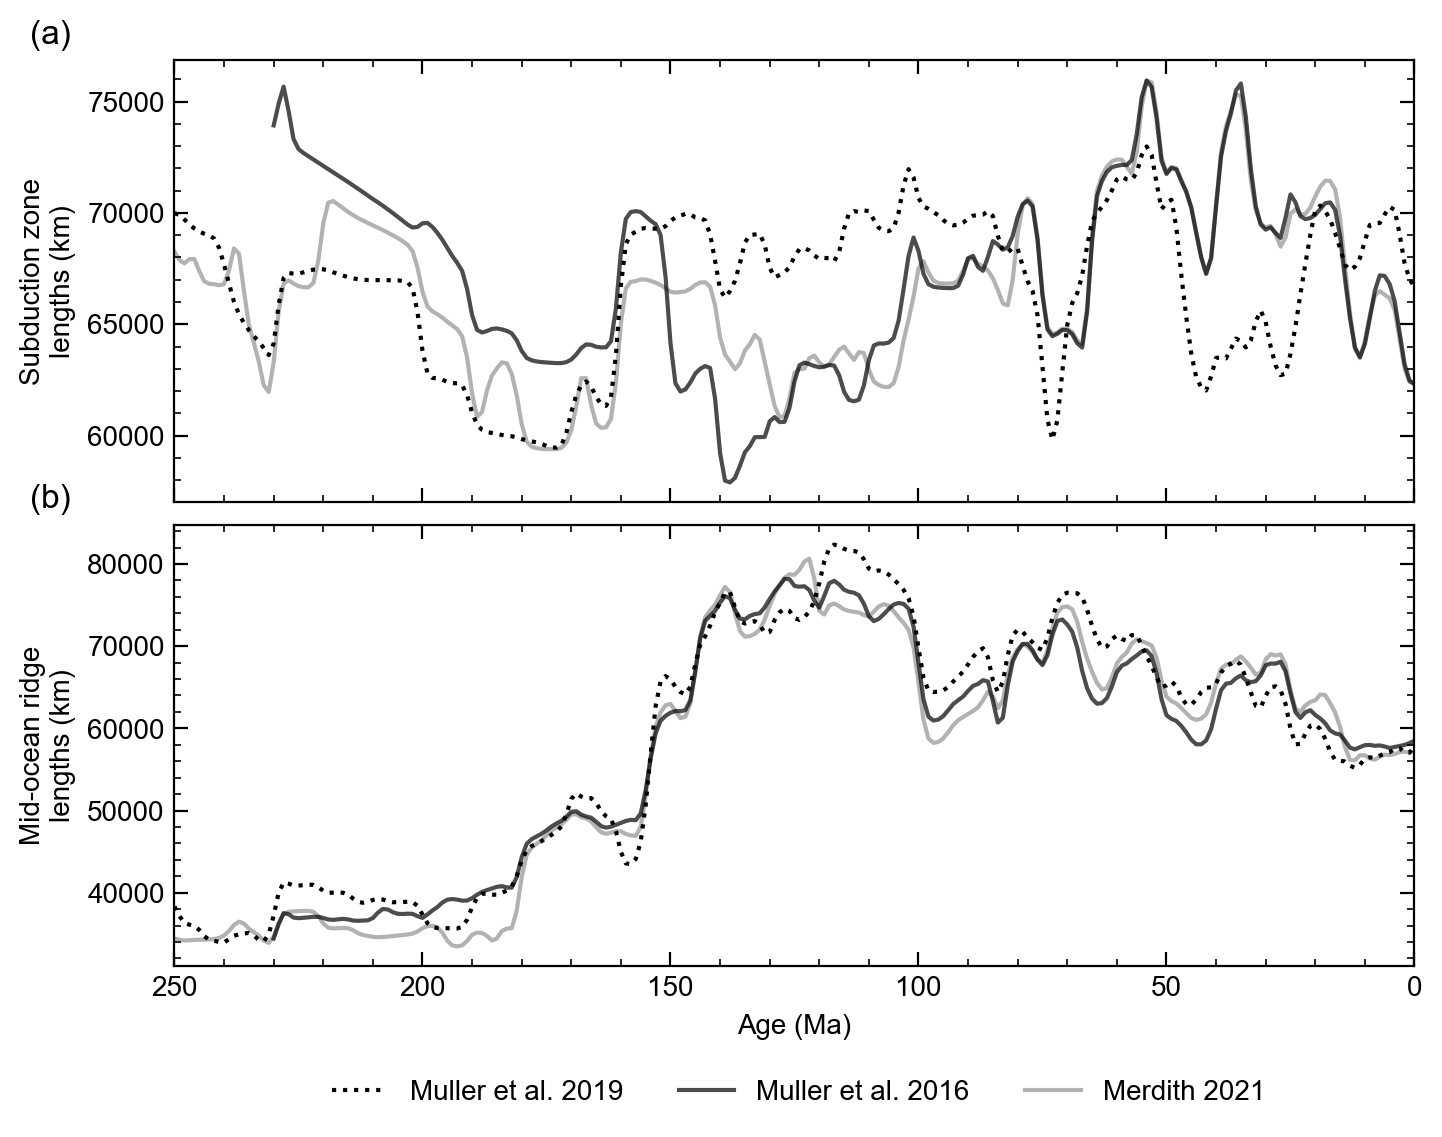

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(8,6), dpi=200)
fig.subplots_adjust(hspace=0.05)
plt.rcParams['font.family'] = 'Arial'
n_axes = len(axes)

# Access subduction zone and ridge lengths from pandas dataframes
muller19_trench_lengths = muller19_df['Global subduction zone lengths (km)'].to_list()
muller16_trench_lengths = muller16_df['Global subduction zone lengths (km)'].to_list()
merdith21_trench_lengths = merdith21_df['Global subduction zone lengths (km)'].to_list()
muller19_ridge_lengths = muller19_df['Global mid-ocean ridge lengths (km)'].to_list()
muller16_ridge_lengths = muller16_df['Global mid-ocean ridge lengths (km)'].to_list()
merdith21_ridge_lengths = merdith21_df['Global mid-ocean ridge lengths (km)'].to_list()


# Prepare different time arrays for each model as Muller 2016 stats start at 230 Ma, while 
# the others start at 250 Ma
muller19_time_array = muller19_df['Time (Ma)'].to_list()
muller16_time_array = muller16_df['Time (Ma)'].to_list()
muller21_time_array = merdith21_df['Time (Ma)'].to_list()


# Subduction zone length plot
axes[0].set_ylabel('Subduction zone\nlengths (km)')
axes[0].set_title("(a)", x=-0.1, y=1, fontsize="12")
axes[0].plot(muller19_time_array, gaussian_filter(muller19_trench_lengths, sigma=1), c='k', linestyle=":", label="Muller et al. 2019")
axes[0].plot(muller16_time_array, gaussian_filter(muller16_trench_lengths,sigma=1), c='k', alpha = 0.7, label='Muller et al. 2016')
axes[0].plot(muller21_time_array, gaussian_filter(merdith21_trench_lengths,sigma=1), c='k', alpha = 0.3, label="Merdith 2021")
axes[0].tick_params(direction="in", length=5, top=True, right=True)
axes[0].tick_params(direction="in", which="minor", length=2.5, top=True, right=True)
axes[0].minorticks_on()

# Mid-ocean ridge length plot
axes[1].set_ylabel('Mid-ocean ridge\nlengths (km)')
axes[1].set_title("(b)", x=-0.1, y=1, fontsize="12")
axes[1].plot(muller19_time_array, gaussian_filter(muller19_ridge_lengths,sigma=1), c='k', linestyle=":", label="Muller et al. 2019")
axes[1].plot(muller16_time_array, gaussian_filter(muller16_ridge_lengths,sigma=1), c='k', alpha = 0.7, label="Muller et al. 2016")
axes[1].plot(muller21_time_array, gaussian_filter(merdith21_ridge_lengths,sigma=1), c='k', alpha = 0.3, label="Merdith 2021")
axes[1].legend(bbox_to_anchor=(0.9, -0.2), ncol = 3, frameon=False)
axes[1].tick_params(direction="in", length=5, top=True, right=True)
axes[1].tick_params(direction="in", which="minor", length=2.5, top=True, right=True)
axes[1].minorticks_on()

# Place tick labels only on the bottom plot
for i, ax in enumerate(axes):
    ax.set_xlim(max_time, min_time)
    if i < n_axes-1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Age (Ma)")

### Global mid-ocean ridge spreading rates and subduction zone convergence rates

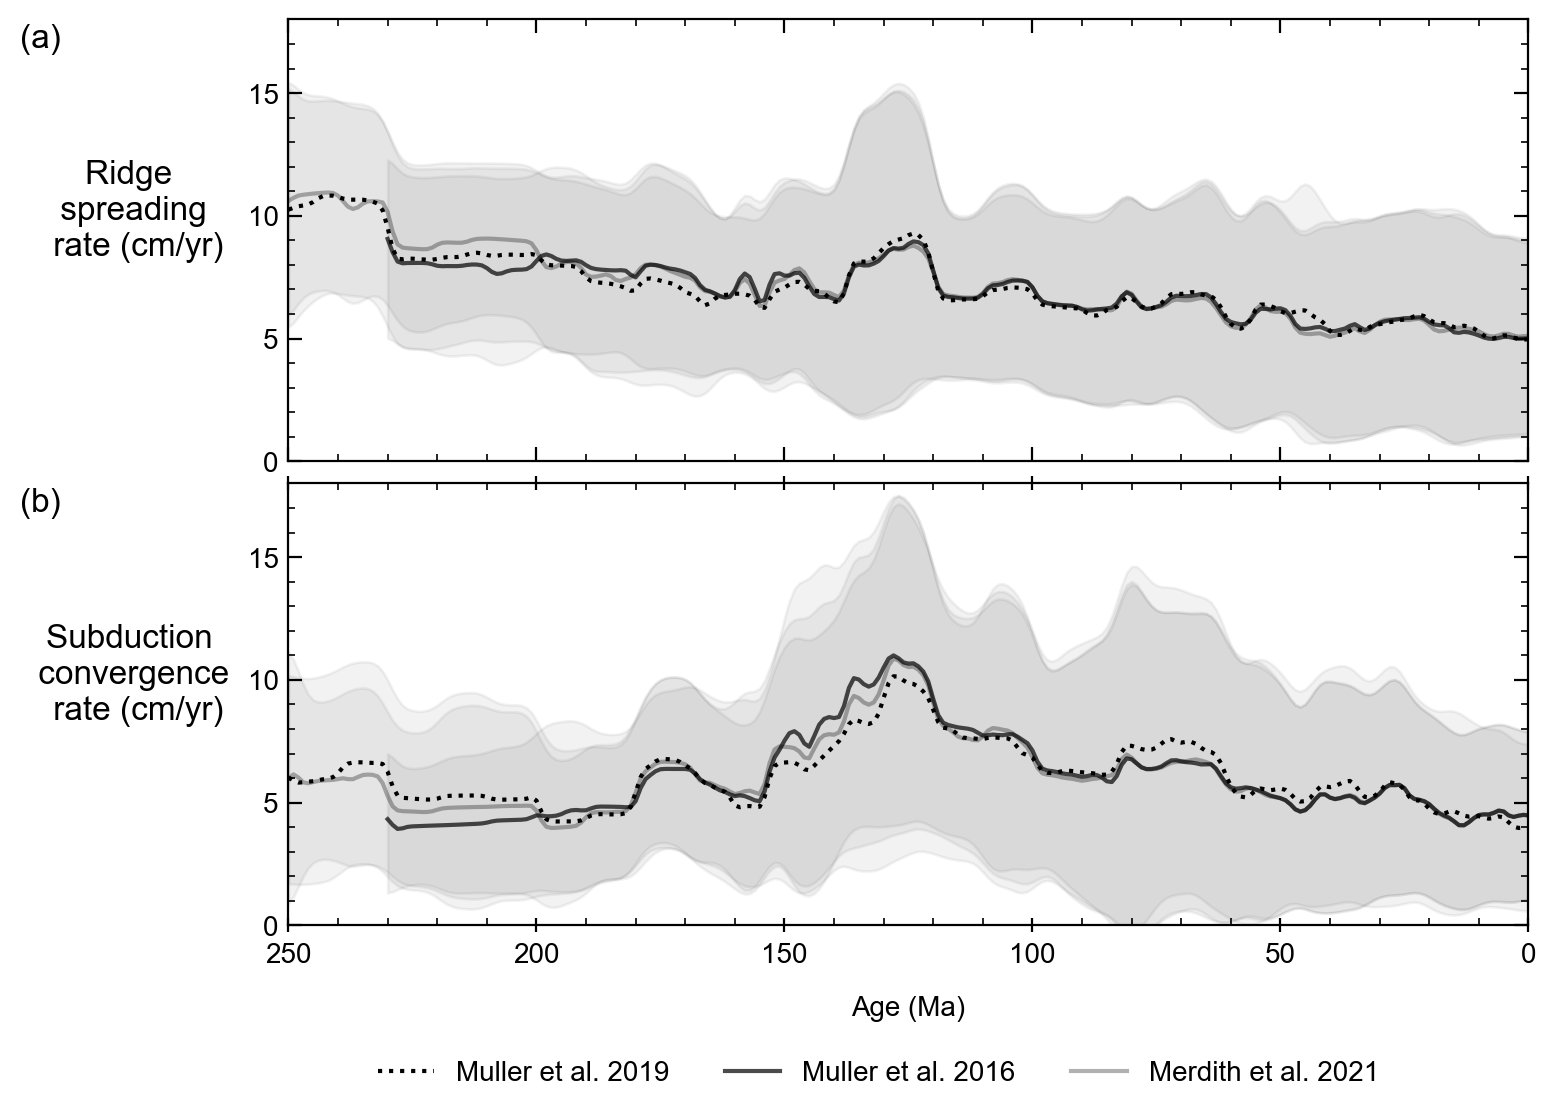

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(8,6), dpi=200)
fig.subplots_adjust(hspace=0.05)
plt.rcParams['font.family'] = 'Arial'
n_axes = len(axes)

# Access subduction convergence and ridge spreading rates (along with their standard deviation) from the dataframes
# Turn lists into numpy arrays.
muller19_subduction_rate = np.array(muller19_df['Mean global ridge velocities (cm/yr)'].to_list())
muller16_subduction_rate = np.array(muller16_df['Mean global ridge velocities (cm/yr)'].to_list())
merdith21_subduction_rate = np.array(merdith21_df['Mean global ridge velocities (cm/yr)'].to_list())
muller19_subduction_rate_sd = np.array(muller19_df['Global ridge velocity standard deviation (cm/yr)'].to_list())
muller16_subduction_rate_sd = np.array(muller16_df['Global ridge velocity standard deviation (cm/yr)'].to_list())
merdith21_subduction_rate_sd = np.array(merdith21_df['Global ridge velocity standard deviation (cm/yr)'].to_list())

muller19_spreading_rate = np.array(muller19_df['Mean global subduction velocities (cm/yr)'].to_list())
muller16_spreading_rate = np.array(muller16_df['Mean global subduction velocities (cm/yr)'].to_list())
merdith21_spreading_rate = np.array(merdith21_df['Mean global subduction velocities (cm/yr)'].to_list())
muller19_spreading_rate_sd = np.array(muller19_df['Global subduction velocity standard deviation (cm/yr)'].to_list())
muller16_spreading_rate_sd = np.array(muller16_df['Global subduction velocity standard deviation (cm/yr)'].to_list())
merdith21_spreading_rate_sd = np.array(merdith21_df['Global subduction velocity standard deviation (cm/yr)'].to_list())

# Subduction convergence rates with standard deviation
axes[0].set_ylabel('Ridge \n spreading \n rate (cm/yr)', rotation="horizontal", fontsize="12")
axes[0].yaxis.set_label_coords(-0.125, 0.45)
axes[0].set_title("(a)", x=-0.2, y=0.9, fontsize="12")
axes[0].set_ylim([0, 18])
# Muller et al. 2019
axes[0].plot(muller19_time_array, gaussian_filter(muller19_subduction_rate, sigma=1), c='k', linestyle=":", label="Muller et al. 2019")
axes[0].fill_between(muller19_time_array, 
                 gaussian_filter(muller19_subduction_rate-muller19_subduction_rate_sd, sigma=2), 
                 gaussian_filter(muller19_subduction_rate+muller19_subduction_rate_sd, sigma=2),
                 edgecolor='k', color='k', alpha=0.05)
# Muller et al. 2016
axes[0].plot(muller16_time_array, gaussian_filter(muller16_subduction_rate,sigma=1), c='k', alpha = 0.7, label='Muller et al. 2016')
axes[0].fill_between(muller16_time_array, 
                 gaussian_filter(muller16_subduction_rate-muller16_subduction_rate_sd, sigma=2), 
                 gaussian_filter(muller16_subduction_rate+muller16_subduction_rate_sd, sigma=2),
                 edgecolor='k', color='k', alpha=0.05)
# Merdith 2021
axes[0].plot(merdith21_time_array, gaussian_filter(merdith21_subduction_rate,sigma=1), c='k', alpha = 0.3, label="Merdith et al. 2021")
axes[0].fill_between(merdith21_time_array, 
                 gaussian_filter(merdith21_subduction_rate-merdith21_subduction_rate_sd, sigma=2), 
                 gaussian_filter(merdith21_subduction_rate+merdith21_subduction_rate_sd, sigma=2),
                 edgecolor='k', color='k', alpha=0.05)
# Tick labels
axes[0].tick_params(direction="in", length=5, top=True, right=True)
axes[0].tick_params(direction="in", length=5, top=True, right=True)
axes[0].tick_params(direction="in", which="minor", length=2.5, top=True, right=True)
axes[0].minorticks_on()


# Mid-ocean ridge spreading rates with standard deviation
axes[1].set_ylabel('Subduction \n convergence \n rate (cm/yr)', rotation="horizontal", fontsize="12")
axes[1].yaxis.set_label_coords(-0.125, 0.45)
axes[1].set_title("(b)", x=-0.2, y=0.9, fontsize="12")
axes[1].set_ylim([0, 18])
axes[1].plot(muller19_time_array, gaussian_filter(muller19_spreading_rate,sigma=1), c='k', linestyle=":", label="Muller et al. 2019")
axes[1].fill_between(muller19_time_array, 
                 gaussian_filter(muller19_spreading_rate-muller19_spreading_rate_sd, sigma=2), 
                 gaussian_filter(muller19_spreading_rate+muller19_spreading_rate_sd, sigma=2),
                 edgecolor='k', color='k', alpha=0.05)

axes[1].plot(muller16_time_array, gaussian_filter(muller16_spreading_rate,sigma=1), c='k', alpha = 0.7, label="Muller et al. 2016")
axes[1].fill_between(muller16_time_array, 
                 gaussian_filter(muller16_spreading_rate-muller16_spreading_rate_sd, sigma=2), 
                 gaussian_filter(muller16_spreading_rate+muller16_spreading_rate_sd, sigma=2),
                 edgecolor='k', color='k', alpha=0.05)

axes[1].plot(merdith21_time_array, gaussian_filter(merdith21_spreading_rate,sigma=1), c='k', alpha = 0.3, label="Merdith et al. 2021")
axes[1].fill_between(merdith21_time_array, 
                 gaussian_filter(merdith21_spreading_rate-merdith21_spreading_rate_sd, sigma=2), 
                 gaussian_filter(merdith21_spreading_rate+merdith21_spreading_rate_sd, sigma=2),
                 edgecolor='k', color='k', alpha=0.05)

axes[1].legend(bbox_to_anchor=(0.9, -0.25), ncol = 3, frameon=False)
axes[1].tick_params(direction="in", length=5, top=True, right=True)
axes[1].tick_params(axis="x", which="major", direction="inout", length=5)
axes[1].tick_params(direction="in", which="minor", length=2.5, top=True, right=True)
axes[1].minorticks_on()

# Place tick labels on the bottom plot only.
for i, ax in enumerate(axes):
    ax.set_xlim(max_time, min_time)
    if i < n_axes-1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Age (Ma)", labelpad=10)


### Global rates of crustal production and destruction

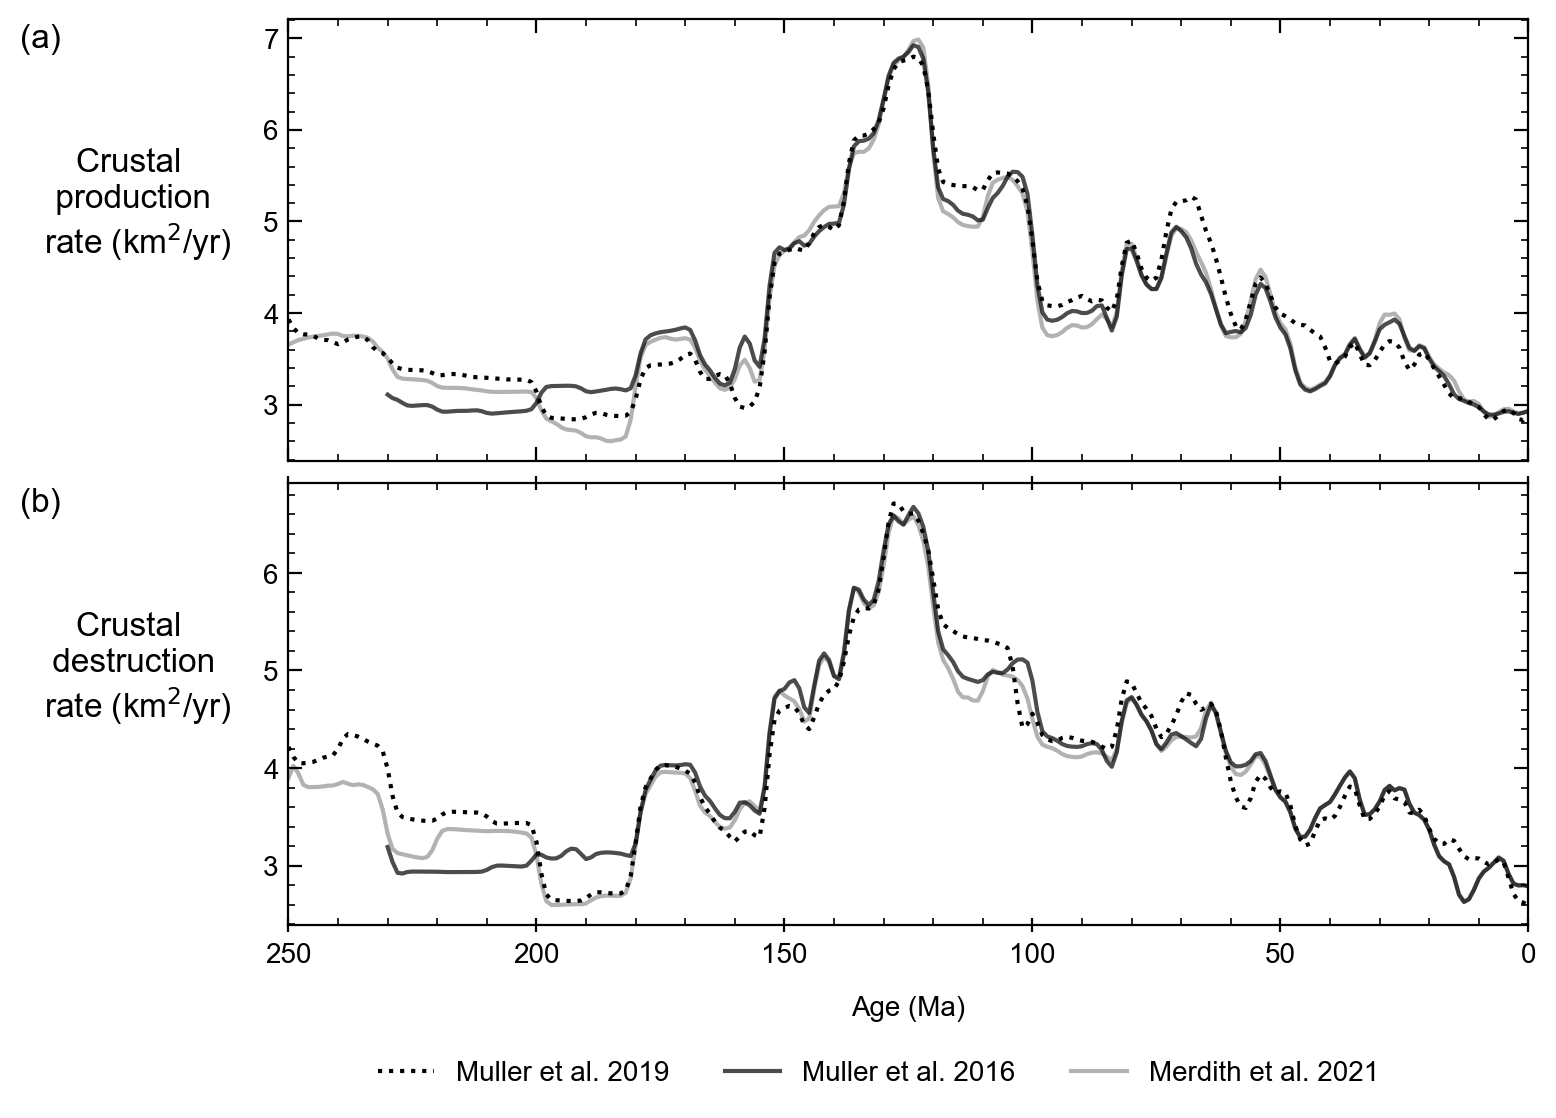

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(8,6), dpi=200)
fig.subplots_adjust(hspace=0.05)
plt.rcParams['font.family'] = 'Arial'
n_axes = len(axes)


# Access crustal production and destruction rates from the dataframes
# Turn lists into numpy arrays.
muller19_crustal_production_rate = np.array(muller19_df['Surface area of crust produced at ridges (km^2/yr)'].to_list())
muller16_crustal_production_rate = np.array(muller16_df['Surface area of crust produced at ridges (km^2/yr)'].to_list())
merdith21_crustal_production_rate = np.array(merdith21_df['Surface area of crust produced at ridges (km^2/yr)'].to_list())

muller19_crustal_destruction_rate = np.array(muller19_df['Surface area of crust subducted at trenches (km^2/yr)'].to_list())
muller16_crustal_destruction_rate = np.array(muller16_df['Surface area of crust subducted at trenches (km^2/yr)'].to_list())
merdith21_crustal_destruction_rate = np.array(merdith21_df['Surface area of crust subducted at trenches (km^2/yr)'].to_list())


# Crustal production rates
axes[0].set_ylabel('Crustal \n production \n rate (km$^2$/yr)', rotation="horizontal", fontsize="12")
axes[0].yaxis.set_label_coords(-0.125, 0.45)
axes[0].set_title("(a)", x=-0.2, y=0.9, fontsize="12")

axes[0].plot(muller19_time_array, gaussian_filter(muller19_crustal_production_rate, sigma=1), c='k', linestyle=":", label="Muller et al. 2019")
axes[0].plot(muller16_time_array, gaussian_filter(muller16_crustal_production_rate,sigma=1), c='k', alpha = 0.7, label='Muller et al. 2016')
axes[0].plot(merdith21_time_array, gaussian_filter(merdith21_crustal_production_rate,sigma=1), c='k', alpha = 0.3, label="Merdith et al. 2021")

# Tick labels
axes[0].tick_params(direction="in", length=5, top=True, right=True)
axes[0].tick_params(direction="in", length=5, top=True, right=True)
axes[0].tick_params(direction="in", which="minor", length=2.5, top=True, right=True)
axes[0].minorticks_on()


# Crustal destruction rates
axes[1].set_ylabel('Crustal \n destruction \n rate (km$^2$/yr)', rotation="horizontal", fontsize="12")
axes[1].yaxis.set_label_coords(-0.125, 0.45)
axes[1].set_title("(b)", x=-0.2, y=0.9, fontsize="12")
axes[1].plot(muller19_time_array, gaussian_filter(muller19_crustal_destruction_rate,sigma=1), c='k', linestyle=":", label="Muller et al. 2019")
axes[1].plot(muller16_time_array, gaussian_filter(muller16_crustal_destruction_rate,sigma=1), c='k', alpha = 0.7, label="Muller et al. 2016")
axes[1].plot(merdith21_time_array, gaussian_filter(merdith21_crustal_destruction_rate,sigma=1), c='k', alpha = 0.3, label="Merdith et al. 2021")

axes[1].legend(bbox_to_anchor=(0.9, -0.25), ncol = 3, frameon=False)
axes[1].tick_params(direction="in", length=5, top=True, right=True)
axes[1].tick_params(axis="x", which="major", direction="inout", length=5)
axes[1].tick_params(direction="in", which="minor", length=2.5, top=True, right=True)
axes[1].minorticks_on()

# Place tick labels on the bottom plot only.
for i, ax in enumerate(axes):
    ax.set_xlim(max_time, min_time)
    if i < n_axes-1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Age (Ma)", labelpad=10)

fig.savefig("crustal_production_destruction.pdf", bbox_inches='tight')